In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib
import numpy as np
from astropy.timeseries import LombScargle
from astropy import units as u
from astropy import constants as const
from scipy.optimize import bisect

In [14]:
#Load in some data to plot as examples
kelt = 'kelt_clipped.csv'
stella = 'stella_rv.dat'
df_kelt = pd.read_csv(kelt)
frequency, power = LombScargle(df_kelt.hjd, df_kelt.mag).autopower(maximum_frequency=0.2)
period = 1/frequency[np.argmax(power)] * 2
df_kelt['phase'] = ((df_kelt.hjd - df_kelt.hjd.min()) % period)/period
df_stella = pd.read_table(stella, delim_whitespace=True)
df_stella['phase'] = ((df_stella.BJD - df_kelt.hjd.min()) % period)/period
df_stella['phi'] = df_stella.phase * 2*np.pi

cos_term = np.cos(df_stella.phi)
sin_term = np.sin(df_stella.phi)
a0 = np.ones(len(sin_term))
A_matrix = np.column_stack((a0, cos_term, sin_term))
xhat, residuals, rank, s = np.linalg.lstsq(
        A_matrix, df_stella.RV, rcond=None)
amp = np.sqrt(xhat[1]**2+xhat[2]**2)
delta = np.arctan(-xhat[2]/xhat[1])

model_vals = amp*np.cos(df_stella.phi+delta)+xhat[0]
df_stella['model'] = model_vals
df_stella = df_stella.sort_values(by='phase', ascending=True).reset_index(drop=True)

## Change the axis to look publication-ready

The default options for plot borders, ticks can be easily changed with this plotparams function

In [8]:
def plotparams(ax):
    '''
    Basic plot params 

    :param ax: axes to modify

    :type ax: matplotlib axes object

    :returns: modified matplotlib axes object
    '''
    ax.minorticks_on()
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    ax.tick_params(direction='in', which='both', labelsize=15)
    ax.tick_params('both', length=8, width=1.8, which='major')
    ax.tick_params('both', length=4, width=1, which='minor')
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(1.5)
    return ax

Example of using this function

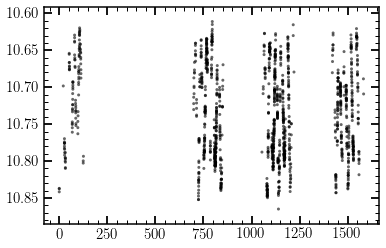

In [9]:
fig, ax = plt.subplots(1, 1)
ax = plotparams(ax) # Just pass the ax as an argument
ax.scatter(df_kelt.hjd-df_kelt.hjd.min(), df_kelt.mag, 
           marker='.', color='black', edgecolor='none', alpha=0.6)
ax.invert_yaxis()

## Using multiple subplots

Here is an example of showing two plots on one figure and also showing how to add a textbox

Text(0.95, 0.95, '$P=30.03$')

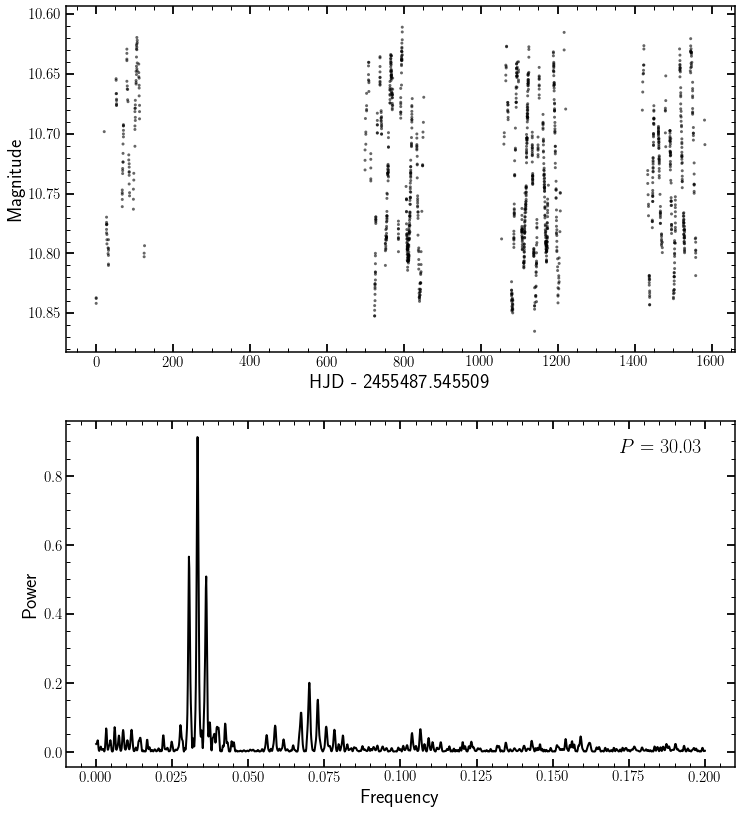

In [10]:
fig, ax = plt.subplots(2, 1, figsize=(12, 14)) ##This figsize argument also changes the output size
ax[0] = plotparams(ax[0])
ax[1] = plotparams(ax[1])

ax[0].scatter(df_kelt.hjd-df_kelt.hjd.min(), df_kelt.mag, 
           marker='.', color='black', edgecolor='none', alpha=0.6)
ax[0].invert_yaxis()
ax[0].set_xlabel(f'HJD - {df_kelt.hjd.min()}', fontsize=20)
ax[0].set_ylabel('Magnitude', fontsize=20)

ax[1].plot(frequency, power, color='black', lw=2)
ax[1].set_xlabel('Frequency', fontsize=20)
ax[1].set_ylabel('Power', fontsize=20)


#Example of adding a text box. The first two arguments give the (x,y) position in axes fraction (so zero to one)
#The third argument is the text
ax[1].text(.95, .95, r'$P={}$'.format(round(1/frequency[np.argmax(power)], 2)), ha='right', va='top',
        fontsize=20, transform=ax[1].transAxes)

## Double Axis

Sometimes it is useful to show two sets of data that have the same xaxis but different yaxis on one plot. This function creates a second ax that shares the same ax as the original. Here is an example show the light curve and radial velocity curve in one plot:

Text(0, 0.5, 'RV (km/s)')

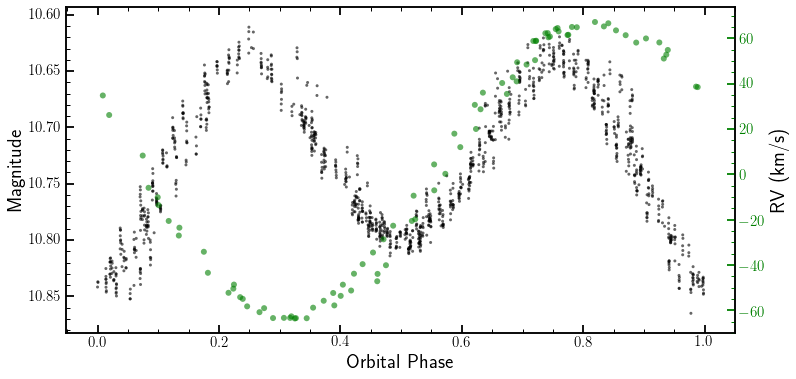

In [13]:
def DoubleY(ax, colors=('black', 'black')):
    '''
    Create a double y axis with two seperate colors
    :param ax: axes to modify
    :type ax: matplotlib axes object
    :param colors: 2-tuple of axes colors
    :type colors: tuple length 2
    :returns: two axes, modified original and new y scale
    '''
    if (type(colors) != tuple) or (len(colors) != 2):
        raise TypeError("colors must be 2-tuple")
    ax2 = ax.twinx()
    ax.minorticks_on()
    ax.xaxis.set_ticks_position('both')
    for a in [ax, ax2]:
        a.minorticks_on()
        a.tick_params(direction='in', which='both', labelsize=15)
        a.tick_params('both', length=8, width=1.8, which='major')
        a.tick_params('both', length=4, width=1, which='minor')
        for axis in ['top', 'bottom', 'left', 'right']:
            a.spines[axis].set_linewidth(1.5)
    ax.tick_params('y', colors=colors[0], which='both')
    ax2.tick_params('y', colors=colors[1], which='both')

    return ax, ax2


fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax = plotparams(ax)
ax, ax2 = DoubleY(ax, colors=('black', 'green'))

#left axis for LC
ax.scatter(df_kelt.phase, df_kelt.mag, marker='.', color='black', edgecolor='none', alpha=0.6)
ax.set_xlabel('Orbital Phase', fontsize=20)
ax.set_ylabel('Magnitude', fontsize=20)
ax.invert_yaxis()

#right axis for RV
ax2.scatter(df_stella.phase, df_stella.RV, marker='o', color='green', edgecolor='none', alpha=0.6)
ax2.set_xlabel('Orbital Phase', fontsize=20)
ax2.set_ylabel('RV (km/s)', fontsize=20)



It doesn't look great for this data set, but could be useful if you were showing multiple histograms or something

## Getting colors from colormaps

Choosing colors can suck, especially if you are using multiple lines to show how a model varies with some parameter. 

As an example, the brightness of a galaxy at a distances R from the center is often described by a sersic profile. A parmater of this model is the sersic index $n$, which controls how curved the profile is. More information on the sersic profile can be found on the [wikipedia page](https://en.wikipedia.org/wiki/S%C3%A9rsic_profile), but lets plot the profile for different $n$ with colors from [iwanthue](https://medialab.github.io/iwanthue/)

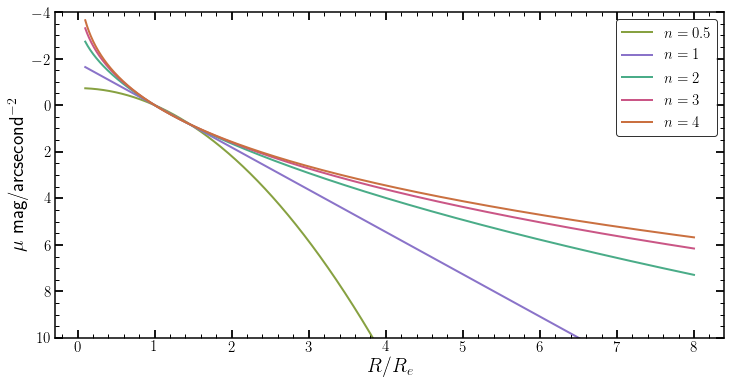

In [19]:
colors = ["#87a141","#8a73c9","#4aac88","#ca5686","#ca7040"]

def SersicMu(frac_r, n, Ie):
    intensity = Ie*np.power(10, -bn(n)*((frac_r)**(1/n) - 1))
    return -2.5*np.log10(intensity)

def bn(n):
    return 0.868*n-0.142

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax = plotparams(ax)

rvals = np.linspace(0.1, 8, 1000)
nvals = [0.5, 1, 2, 3, 4]
for i in range(len(nvals)):
    yvals = SersicMu(rvals, nvals[i], 1)
    ax.plot(rvals, yvals, color=colors[i], label=r'$n={}$'.format(str(nvals[i])), lw=2)


ax.invert_yaxis()
ax.set_ylim(bottom=10, top=-4)
ax.set_xlabel(r'$R/R_e$', fontsize=20)
ax.set_ylabel(r'$\mu$ mag/arcsecond$^{-2}$', fontsize=20)
ax.legend(loc='upper right', edgecolor='black', fontsize=15)

This looks okay, but the colors aren't really related to $n$ in any logical way. Luckily, we can use colormaps from matplotlib to select colors that follow some pattern. 

The [matplotlib documentation](https://matplotlib.org/stable/tutorials/colors/colormaps.html) shows the default colormaps. These are often used if you are make some density or heat plot. We can also extract sets of colors to use for our sersic profile lines:

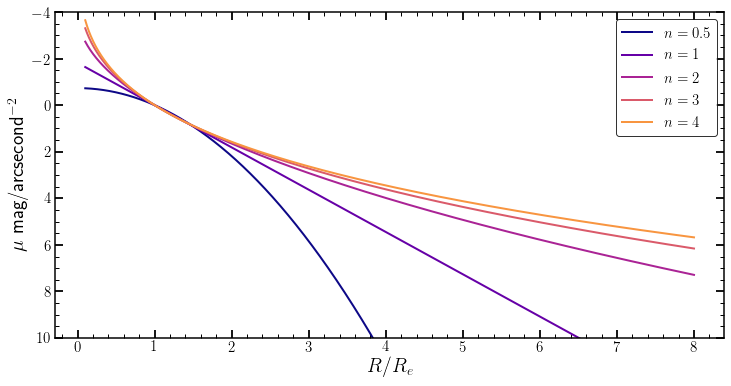

In [23]:
def get_colors(vals, cmap='plasma'):

    if isinstance(plt.get_cmap(cmap), matplotlib.colors.ListedColormap):
        return [ plt.get_cmap(cmap).colors[i]
                 for i in np.linspace(
                        0, int(0.75*len(plt.get_cmap(cmap).colors)),
                        len(vals), dtype=int)]
    elif isinstance(plt.get_cmap(cmap), matplotlib.colors.LinearSegmentedColormap):
        return [ plt.get_cmap(cmap)(np.arange(0, plt.get_cmap(cmap).N))[i]
                 for i in np.linspace(
                        0, int(0.75*plt.get_cmap(cmap).N),
                        len(vals), dtype=int)]
    

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax = plotparams(ax)

rvals = np.linspace(0.1, 8, 1000)
nvals = [0.5, 1, 2, 3, 4]

#Get the colors from the plasma colormap
colors = get_colors(nvals, cmap='plasma')

for i in range(len(nvals)):
    yvals = SersicMu(rvals, nvals[i], 1)
    ax.plot(rvals, yvals, color=colors[i], label=r'$n={}$'.format(str(nvals[i])), lw=2)


ax.invert_yaxis()
ax.set_ylim(bottom=10, top=-4)
ax.set_xlabel(r'$R/R_e$', fontsize=20)
ax.set_ylabel(r'$\mu$ mag/arcsecond$^{-2}$', fontsize=20)
ax.legend(loc='upper right', edgecolor='black', fontsize=15)

In summary, matplotlib is a fairly powerful tool that can be used to produce quick and presentable figures. For some of the coolest astronomy figures created in matplotlib (or similar tools), check out [astro plot of the week](https://twitter.com/PlotAstro) on twitter